In [379]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

ticker = 'EURUSD=X'
data = yf.download(ticker, start='2025-01-01', end='2025-03-28', interval='1h')


[*********************100%***********************]  1 of 1 completed


In [380]:
data.head()

Price,Close,High,Low,Open,Volume
Ticker,EURUSD=X,EURUSD=X,EURUSD=X,EURUSD=X,EURUSD=X
Datetime,,,,,
2025-01-01 05:00:00+00:00,1.035197,1.035197,1.035197,1.035197,0
2025-01-01 18:00:00+00:00,1.035947,1.036592,1.035518,1.035518,0
2025-01-01 19:00:00+00:00,1.036162,1.036269,1.035947,1.035947,0
2025-01-01 20:00:00+00:00,1.036162,1.036269,1.035947,1.036162,0
2025-01-01 21:00:00+00:00,1.035840,1.036162,1.035625,1.036162,0


In [381]:
data.columns

MultiIndex([( 'Close', 'EURUSD=X'),
            (  'High', 'EURUSD=X'),
            (   'Low', 'EURUSD=X'),
            (  'Open', 'EURUSD=X'),
            ('Volume', 'EURUSD=X')],
           names=['Price', 'Ticker'])

In [382]:
data.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

In [383]:
data

,Close,High,Low,Open,Volume
Datetime,,,,,
2025-01-01 05:00:00+00:00,1.035197,1.035197,1.035197,1.035197,0
2025-01-01 18:00:00+00:00,1.035947,1.036592,1.035518,1.035518,0
2025-01-01 19:00:00+00:00,1.036162,1.036269,1.035947,1.035947,0
2025-01-01 20:00:00+00:00,1.036162,1.036269,1.035947,1.036162,0
2025-01-01 21:00:00+00:00,1.035840,1.036162,1.035625,1.036162,0
...,...,...,...,...,...
2025-03-27 19:00:00+00:00,1.079797,1.080147,1.079214,1.079331,0
2025-03-27 20:00:00+00:00,1.080497,1.080497,1.079680,1.079680,0
2025-03-27 21:00:00+00:00,1.080264,1.080264,1.079797,1.080264,0


In [384]:
data['MA20'] = data['Close'].rolling(window=20).mean()
data['MA50'] = data['Close'].rolling(window=50).mean()

data = data.dropna()

e:\Anaconda\Lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


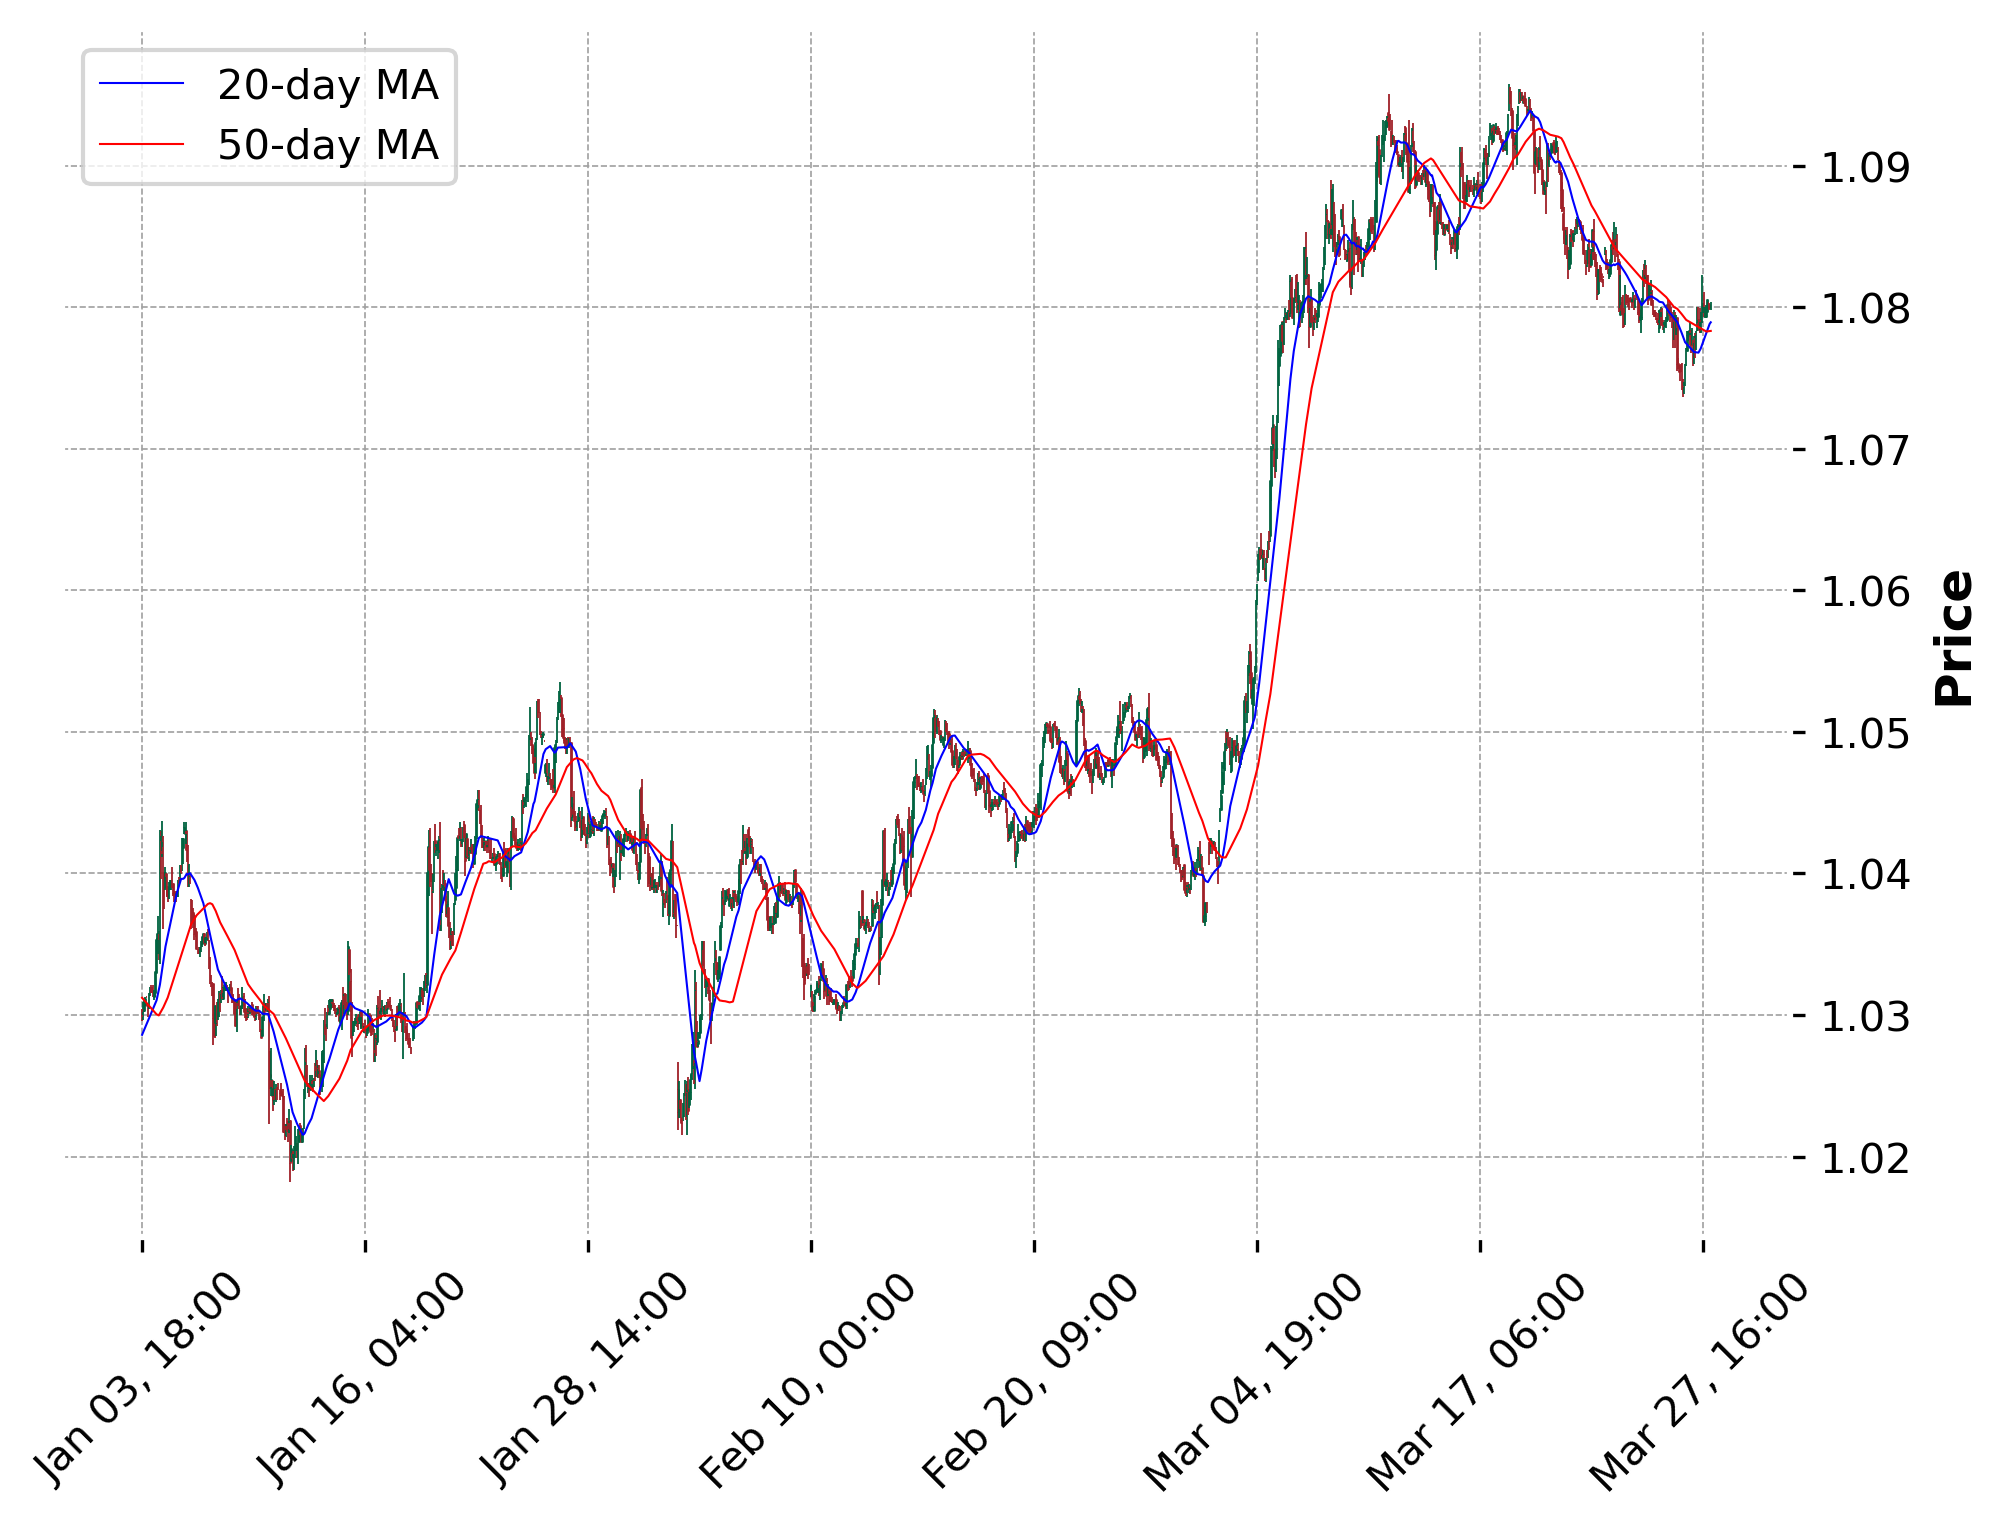

In [385]:
import mplfinance as mpf


# Define the moving average plots
ma_plots = [
    mpf.make_addplot(data['MA20'], color='blue', width=0.5, label='20-day MA'),
    mpf.make_addplot(data['MA50'], color='red', width=0.5, label='50-day MA')
]


fig, ax = mpf.plot(data, type='candle', style='charles', volume=False, addplot=ma_plots, returnfig=True)

# ✅ Set the figure DPI manually
fig.set_dpi(300)

plt.show()

In [386]:
df = data[['Close', 'High', 'Low', 'Open', 'MA20', 'MA50']]

In [387]:
df['Signal'] = np.where(df['MA20'] > df['MA50'], 1, 0)
df['Signal'] = df['Signal'].diff()

In [388]:
df['Buy_Signal'] = np.where(df['Signal'] == 1, df['Close'], np.nan)
df['Sell_Signal'] = np.where(df['Signal'] == -1, df['Close'], np.nan)

e:\Anaconda\Lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


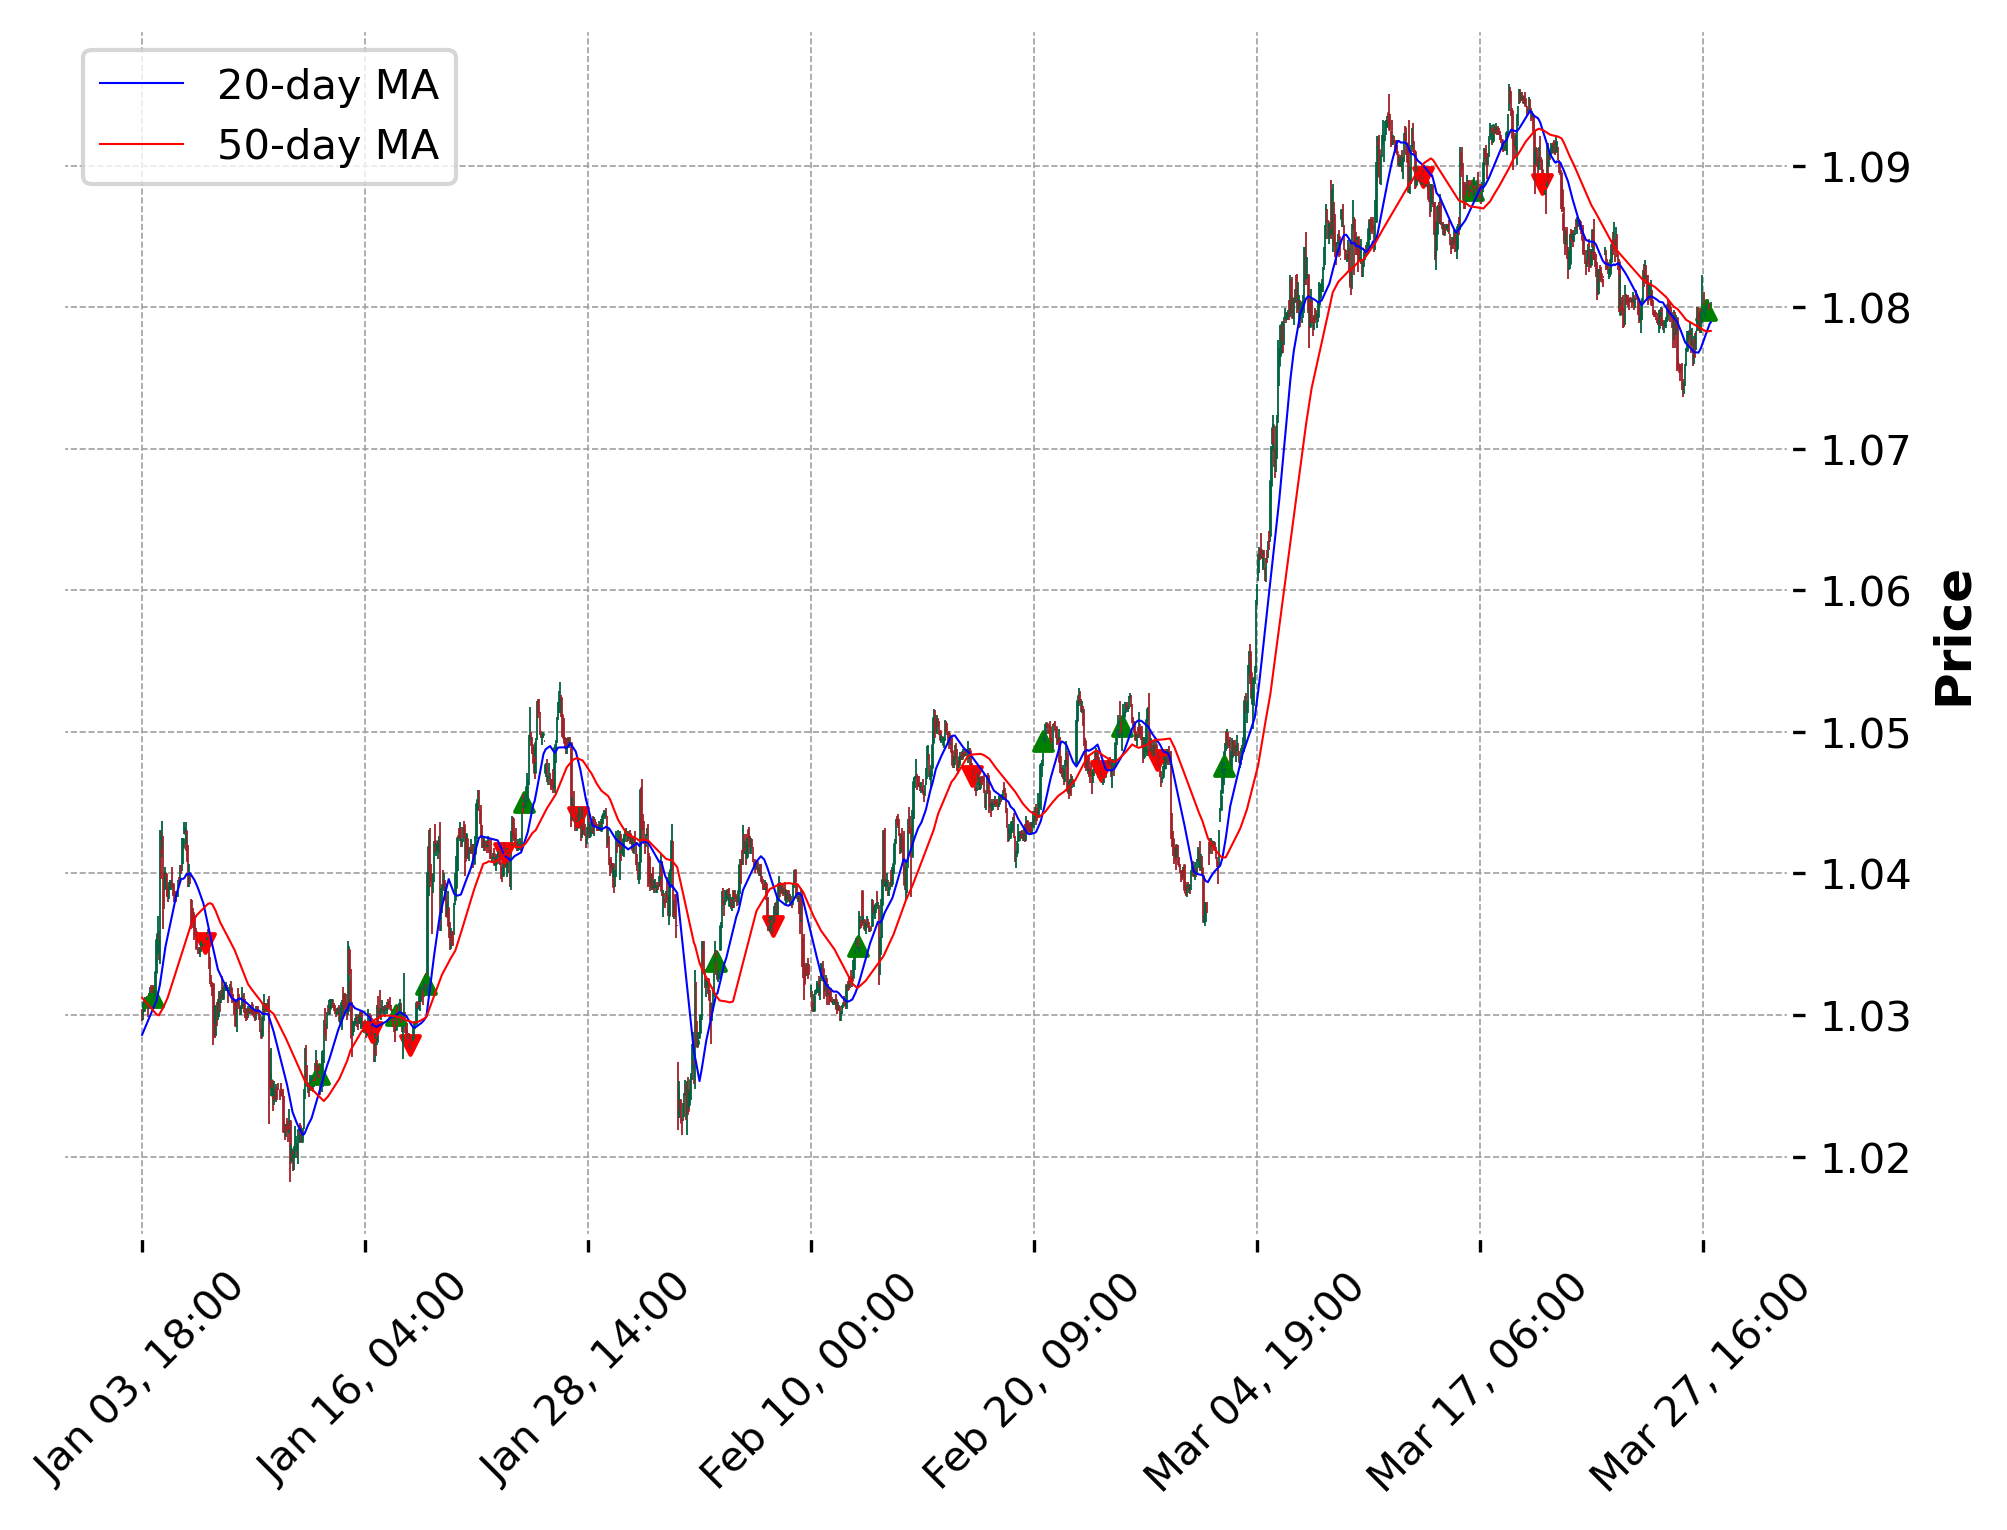

In [389]:
buy_plot = mpf.make_addplot(df['Buy_Signal'], type='scatter', marker='^', color='green', markersize=20)
sell_plot = mpf.make_addplot(df['Sell_Signal'], type='scatter', marker='v', color='red', markersize=20)

ma_20 = mpf.make_addplot(data['MA20'], color='blue', width=0.5, label='20-day MA')
ma_50 = mpf.make_addplot(data['MA50'], color='red', width=0.5, label='50-day MA')

# Plot candlestick chart with moving averages and signals
fig, ax = mpf.plot(df[['Close', 'Open', 'Low', 'High']], type='candle', style='charles', volume=False, 
         addplot=[buy_plot, sell_plot, ma_20, ma_50], returnfig=True)

# ✅ Set the figure DPI manually
fig.set_dpi(300)

plt.show()

In [ ]:
def backtest_strategy(initial_balance, risk_per_trade, one_pip, exchange_rate):
    """
    Backtests an MA crossover strategy with risk-based position sizing.

    Parameters:
    - df: DataFrame with 'Signal' (1 = Buy, -1 = Sell) and 'Close' price.
    - initial_balance: Starting capital.
    - risk_per_trade: Fraction of capital risked per trade (e.g., 0.02 for 2%).
    - one_pip: Pip value.
    - lot_size: Standard lot size (1 lot = 100,000 units).
    - exchange_rate: Exchange rate for pip value calculation.

    Returns:
    - final balance and a DataFrame with equity curve.
    """

    # Convert lot size
    lot_size = 100000  
    pip_value = (one_pip * lot_size) / exchange_rate  

    # Initialize variables
    balance = initial_balance
    position = 0
    trade_size = 0  
    buy_price = 0  
    sell_price = 0  

    df['Balance'] = np.zeros(len(df))
    trades = []  # Store trade details

    for i in range(len(df)):
        if df['Signal'].iloc[i] == 1 and position == 0:  # Buy
            position = 1
            buy_price = df['Close'].iloc[i]
            trade_size = (balance * risk_per_trade) / (10 * one_pip * pip_value * lot_size)  # Risk-based sizing
            print(trade_size)
        elif df['Signal'].iloc[i] == -1 and position == 1:  # Sell
            position = 0
            sell_price = df['Close'].iloc[i]
            trade_profit = (sell_price - buy_price) * (1 / one_pip) * pip_value * trade_size  
            balance += trade_profit
            df['Balance'].iloc[i] = balance  # Update balance in DataFrame
            trades.append({'Entry': buy_price, 'Exit': sell_price, 'Profit': trade_profit})
        elif df['Signal'].iloc[i] == -1 and position == 0:  # Short Sell
            position = -1
            sell_price = df['Close'].iloc[i]
            trade_size = (balance * risk_per_trade) / (10 * one_pip * pip_value * lot_size)  
        elif df['Signal'].iloc[i] == 1 and position == -1:  # Buy to Close Short
            position = 0
            buy_price = df['Close'].iloc[i]
            trade_profit = (sell_price - buy_price) * (1 / one_pip) * pip_value * trade_size  
            balance += trade_profit
            df['Balance'].iloc[i] = balance
            trades.append({'Entry': sell_price, 'Exit': buy_price, 'Profit': trade_profit})

    return balance, pd.DataFrame(trades)


0.22000000000000003
1.001690845489502
1.0059201513216112
0.9957403784256882
1.01841107793514
0.997777820066151
1.0049169229895942
1.0241699264505364
0.9957231673570199
0.995177003891939
1.0828917140306664
1.0010265296590295
Total Profit: $1271.25
Total Trades: 11


C:\Users\ASUS\AppData\Local\Temp\ipykernel_9200\1193533322.py:43: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['Balance'].iloc[i] = balance  # Update balance in DataFrame
C:\Users\ASUS\AppData\Local\Temp\ipykernel_9200\1193533322.py:43: 

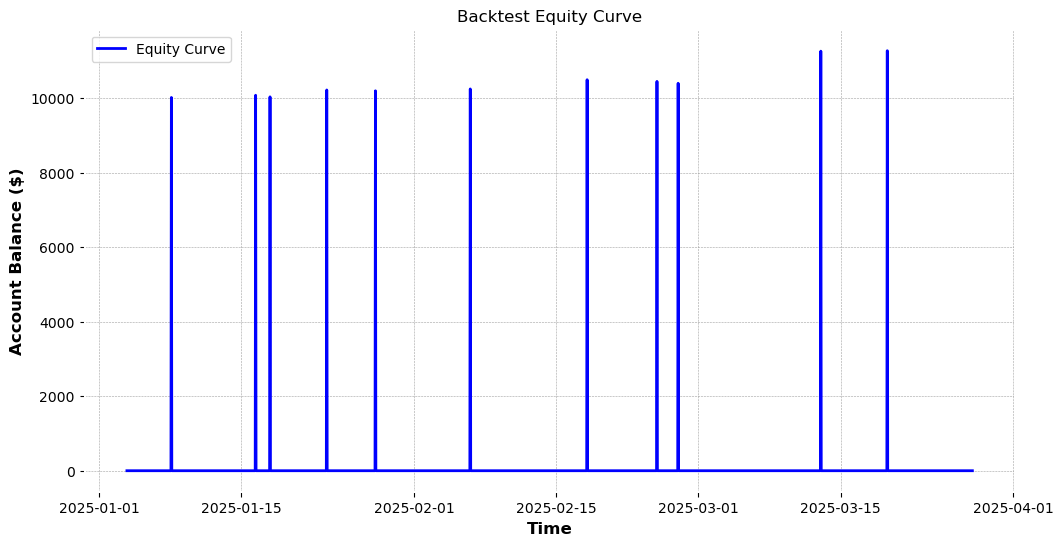

In [429]:
def analyze_results(initial_balance, risk_per_trade, one_pip=0.0001, exchange_rate=1.1):
    """
    Analyzes backtest results: prints profit, trade stats, and plots the equity curve.

    Parameters:
    - df: DataFrame with signals and prices.
    - initial_balance: Starting capital.
    - risk_per_trade: Risk per trade as a fraction of capital.
    - one_pip: Pip value.
    - lot_size: Standard lot size (1 lot = 100,000 units).
    - exchange_rate: Exchange rate for pip calculation.
    """

    final_balance, trades = backtest_strategy(initial_balance, risk_per_trade, one_pip, exchange_rate)
    
    # Calculate total profit
    total_profit = final_balance - initial_balance
    print(f"Total Profit: ${total_profit:.2f}")
    
    # Number of trades
    num_trades = len(trades)
    print(f"Total Trades: {num_trades}")

    # Plot equity curve
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['Balance'], label="Equity Curve", color='blue')
    plt.xlabel("Time")
    plt.ylabel("Account Balance ($)")
    plt.title("Backtest Equity Curve")
    plt.legend()
    plt.show()
    
    return trades  # Returning trades DataFrame for further analysis

# Example usage
trades_df = analyze_results(10000, 0.02)
